In [1]:
import pandas as pd
import numpy as np
import cv2
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib.image import imread
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as K
from keras import applications

In [12]:
from typing import List
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.neighbors import NearestNeighbors

from sklearn.pipeline import Pipeline

In [16]:
# Use only 1000 images when True
SUBMIT=False
DEBUG = True

# Defining which part of the model is being used
IMG = True
EXTRA_LAYERS = False
TEXT = True
PHASH = True
SIM_PHASH = True

#Defining the path to the images and properties
PATH = './data/shopee-product-matching/'
MODEL_PATH = "./models/efficientnetb5_notop.h5"
IMG_SIZE = 456 # avg img size = 444, EfficientNetB5 = 456
BATCH = 5000
IMG_SIM_THRESHOLD = 0.25
TEXT_SIM_THRESHOLD = 0.45
PHASH_SIM_THRESHOLD = 6

In [5]:
test = pd.read_csv(PATH + 'test.csv')
train = pd.read_csv(PATH + 'train.csv')

In [6]:
if DEBUG:
    train = train.sample(n = 1000).reset_index(drop = True)

if SUBMIT: 
    img_path = PATH +"/test_images/"
    train = test 
else:
    img_path = PATH +"train_images/"
    # convert label_group to target
    tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
    train['target'] = train.label_group.map(tmp)
    train

## Classes

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=IMG_SIZE, batch_size=32, path=''): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange( len(self.df) )
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(( (len(self.df)) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes),self.img_size,self.img_size,3),dtype='float32')
        df = self.df.iloc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            img = cv2.imread(self.path + row['image'])
            X[i,] = cv2.resize(img,(self.img_size,self.img_size))
        return X

In [9]:
class ImageFeatureExtractor(BaseEstimator, TransformerMixin):

    def __init__(self, variables: List[str], model_path: str, image_path: str):
        if not isinstance(variables, list):
            raise ValueError("variables should be a list")

        self.variables = variables
        self.model_path = model_path
        self.image_path = image_path

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:

        WGT = self.model_path
        eff_net = tf.keras.applications.efficientnet.EfficientNetB5(weights=WGT, input_shape=None, include_top=False,
                                                                    pooling="avg",
                                                                    drop_connect_rate=0.2)

        data = DataGenerator(X, path=self.image_path)
        model = eff_net

        image_embedding = model.predict(data)
        del (model)
        gc.collect()
        return image_embedding


In [48]:
class DistanceEstimator(BaseEstimator, RegressorMixin):

    def __init__(self, threshold):
        self.threshold = threshold
        self.model = NearestNeighbors(n_neighbors=6, metric="cosine")

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        self.model.fit(X)
        self.names = y
        return self

    def predict(self, X: pd.DataFrame):
        chunk = 10
        cl = len(self.names) // chunk 
        cl += int((len(self.names) % chunk) !=0)
        pred_img = []
        for i in range(cl) :

            a = i * chunk
            b = (i+1) * chunk
            b = min(len(self.names),b)
            distances,indices = self.model.kneighbors(X[a:b,])
            for j in range(b-a):
                distance = distances[j,:]
                ind = np.where(distance < self.threshold)[0]
                IND = indices[j,ind]
                
                near_distance = distance[ind]
                
                result = dict()
                for dist, idx in zip(near_distance, IND):
                    result[idx] = dist

                pred_img.append(result)

        return pred_img

In [49]:
class IndexTransform(BaseEstimator, TransformerMixin):

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        self.names = y

        return self

    def transform(self, X) -> pd.DataFrame:
      
        transformed = []
        for feature in X:
            results = dict()
            for key, values in feature.items():
                results[self.names[key]] = values
            transformed.append(results)

        return transformed

In [50]:
class SanitizeText(BaseEstimator, TransformerMixin):

    def __init__(self, variables: List[str]):

        if not isinstance(variables, list):
            raise ValueError("variables should be a list")

        self.variables = variables
        self.CM_MAP = {"wanita": "woman", "anak": "child", "bayi": "baby", "tas": "bag", "masker": "face mask",
                       "pria": "men", "murah": "cheap", "tangan": "hand", "alat": "tool", "motif": "motive",
                       "warna": "color", "bahan": "material", "celana": "pants", "baju": "clothes", "kaos": "t-shirt",
                       "sepatu": "shoes", "rambut": "hair", "mainan": "toy", "sarung": "holster", "polos": "plain",
                       "rak": "rack", "botol": "bottle", "sabun": "soap", "kain": "fabric", "panjang": "long",
                       "kabel": "cable", "buku": "book", "plastik": "plastic", "mobil": "car", "hitam": "black",
                       "karakter": "character", "putih": "white", "dompet": "purse", "kaki": "feet",
                       "pembersih": "cleaners", "lipat": "folding", "silikon": "silicone", "minyak": "oil",
                       "isi": "contents", "paket": "package", "susu": "milk", "gamis": "robe", "mandi": "bath",
                       "madu": "honey", "kulit": "skin", "serbaguna": "multipurpose", "bisa": "can",
                       "kacamata": "spectacles", "pendek": "short", "tali": "rope", "selempang": "sash", "topi": "hat",
                       "obat": "drug", "gantungan": "hanger", "tahun": "year", "jilbab": "hijab", "dapur": "kitchen",
                       "dinding": "wall", "kuas": "brush", "perempuan": "woman", "katun": "cotton", "sepeda": "bike",
                       "lucu": "funny", "lengan": "arm", "kaca": "glass", "garansi": "warranty", "bunga": "flower",
                       "handuk": "towel", "dewasa": "adult", "elektrik": "electric", "timbangan": "balance",
                       "besar": "big", "bahan": "ingredient", "ransel": "backpack", "kertas": "paper", "lampu": "light",
                       "sepatu": "shoes", "tempat": "place"}

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:

        def remove_patterns(text):
            '''
            Some titles contain " x " as separators.
            Example: train_3369186413
            '''
            patterns = {' x ': ' ',
                        ' a ': ' '}
            for k, v in patterns.items():
                text = text.replace(k, v)
            return text

        # so that we do not over-write the original dataframe
        X = X.copy()

        # letters_only = lambda text: re.sub("[^a-zA-Z]", " ", text)
        lowercase_only = lambda text: text.lower()
        replace_multispace_by_space = lambda text: re.sub('\s+', ' ', text)
        translate_ind_to_eng = lambda text: " ".join(self.CM_MAP.get(w, w) for w in text.split())

        for feature in self.variables:
            X[feature] = (X[feature]
                          .apply(lowercase_only)
                          .apply(remove_patterns)
                          .apply(replace_multispace_by_space)
                          .apply(translate_ind_to_eng))
            return X[feature]

        


In [71]:
class CombinePredictionsTransform(BaseEstimator, TransformerMixin):

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        return self

    def transform(self, X) -> pd.DataFrame:
        X.reset_index()
        results = [self.combine_multi_predictions(row) for row in X.iterrows()]

        X["pred_combined"] = results

        return X

    def combine_multi_predictions(self, row):
        idt = row[1]["posting_id"]
        pred_text = row[1]['text_pred']
        pred_img = row[1]['image_pred']

        pred_text_keys = pred_text.keys()
        pred_img_keys = pred_img.keys()

        result = dict()

        for key in pred_text_keys:

            if key in result:
                continue

            if key == idt:
                continue
            value_text = 1 - pred_text[key] if key in pred_text else 0
            value_img = 1 - pred_img[key] if key in pred_img else 0

            total = value_text + value_img

            result[key] = total

        for key in pred_img_keys:

            if key in result:
                continue

            if key == idt:
                continue

            value_text = 1 - pred_text[key] if key in pred_text else 0
            value_img = 1 - pred_img[key] if key in pred_img else 0

            total = value_text + value_img

            result[key] = total

        return str(result)


## Pipelines

In [51]:
text_pipeline = Pipeline(
    [
        (
            "text_clean",
            SanitizeText(variables=["title"]),
        ),
        (
            "text_vectorize",
            TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english'),
        ),
        (
            "knn_distance",
            DistanceEstimator(threshold=0.25),
        )
    ]
)

In [57]:
image_pipeline = Pipeline(
    [
        (
            "image_features",
            ImageFeatureExtractor(variables=["image"],
                                  model_path=MODEL_PATH,
                                  image_path=img_path),
        ),
        (
            "knn_distance",
            DistanceEstimator(threshold=0.15),
        )
    ]
)

In [90]:
text_pipeline.fit(train, train["posting_id"])
image_pipeline.fit(train, train["posting_id"])

text_pred = text_pipeline.predict(train)
image_pred = image_pipeline.predict(train)


idx_transform = IndexTransform()
train["image_pred"] = idx_transform.fit_transform(image_pred, train["posting_id"])
train["text_pred"] = idx_transform.fit_transform(text_pred, train["posting_id"])

combine_transform = CombinePredictionsTransform()
combine_transform.fit_transform(train)


32/32 [==============================] - 62s 2s/step


,posting_id,image,image_phash,title,label_group,target,image_pred,text_pred,pred_combined
0,train_232287567,6b759e367abdb56992311edbac343fdc.jpg,ee3e91414b3e4e91,PROMO Goon smilebaby renceng S10 termurah,72034655,[train_232287567],{'train_232287567': 1.1920929e-07},{'train_232287567': 0.0},{}
1,train_212580176,dcecd22cdf45b5c951d709119d09253c.jpg,efc1a5a5621a31e3,Gamis Cok,3570475971,[train_212580176],{'train_212580176': 1.7881393e-07},"{'train_212580176': 0.0, 'train_632656690': 0....",{'train_632656690': 0.8413093712112613}
2,train_3129517250,595d3ecfe180324503a14252c0333a87.jpg,b293cdccb63191cc,Nuface Facial Mask Anti Acne,257984140,[train_3129517250],{'train_3129517250': 0.0},{'train_3129517250': 0.0},{}
3,train_1589107157,966f0d9aa711a65443a0d557ad76454e.jpg,eab74f98a94a9485,Balon Foil Angka Hitam 40cm,1281010192,[train_1589107157],{'train_1589107157': 0.0},{'train_1589107157': 0.0},{}
4,train_742215561,a666d914f5a95c433207a36822fad93e.jpg,efe0901fe0e86f90,Little Palmerhaus - Mittens & Booties (Sarung ...,2784788129,[train_742215561],{'train_742215561': 5.9604645e-08},{'train_742215561': 0.0},{}
...,...,...,...,...,...,...,...,...,...
995,train_3493353794,b2d303718be66d1ef02dca8ab7cb4de5.jpg,e89e97618b6e1c64,Garam Himalaya 1 Kg - Pink HimSalt Original Pr...,3062268608,[train_3493353794],{'train_3493353794': 0.0},{'train_3493353794': 0.0},{}
996,train_2087567541,7e27e52853332e1733246e13d4f757ec.jpg,b9ac3e1467623cb1,Chopper Mitochiba CH 200 / CH 100,3568247382,[train_2087567541],{'train_2087567541': 0.0},{'train_2087567541': 0.0},{}
997,train_3321213276,72a40f15c024c1e9a10026f99f30c6cd.jpg,be97c81cc398cc33,Hak Tahu Wanita Gliter SDH185,1307991557,[train_3321213276],{'train_3321213276': 2.3841858e-07},{'train_3321213276': 0.0},{}
998,train_3056228766,a2f571f82256ad7886023c4a2297226f.jpg,bda9e4e1e31d0aa2,Sarung Tangan Cuci Piring Anti Air Rubber Glov...,3715162867,[train_3056228766],{'train_3056228766': 1.1920929e-07},{'train_3056228766': 0.0},{}


In [58]:
text_pipeline.fit(train, train["posting_id"])
text_pred = text_pipeline.predict(train)

In [ ]:
image_pipeline.fit(train)
image_pred = image_pipeline.predict(train)

In [59]:
idx_transform = IndexTransform()
df_image_pred = idx_transform.fit_transform(image_pred, train["posting_id"])
df_text_pred = idx_transform.fit_transform(text_pred, train["posting_id"])

In [86]:
train["image_pred"] = df_image_pred
train["text_pred"] = df_text_pred

In [72]:
combine_transform = CombinePredictionsTransform()
combine_transform.fit_transform(train)

,posting_id,image,image_phash,title,label_group,target,image_pred,text_pred,pred_combined
0,train_232287567,6b759e367abdb56992311edbac343fdc.jpg,ee3e91414b3e4e91,PROMO Goon smilebaby renceng S10 termurah,72034655,[train_232287567],"{'train_232287567': 1.1920929e-07, 'train_2626...",{'train_232287567': 0.0},{'train_2626716730': 0.8059214353561401}
1,train_212580176,dcecd22cdf45b5c951d709119d09253c.jpg,efc1a5a5621a31e3,Gamis Cok,3570475971,[train_212580176],{'train_212580176': 1.7881393e-07},"{'train_212580176': 0.0, 'train_632656690': 0....",{'train_632656690': 0.8413093712112613}
2,train_3129517250,595d3ecfe180324503a14252c0333a87.jpg,b293cdccb63191cc,Nuface Facial Mask Anti Acne,257984140,[train_3129517250],{'train_3129517250': 0.0},{'train_3129517250': 0.0},{}
3,train_1589107157,966f0d9aa711a65443a0d557ad76454e.jpg,eab74f98a94a9485,Balon Foil Angka Hitam 40cm,1281010192,[train_1589107157],{'train_1589107157': 0.0},{'train_1589107157': 0.0},{}
4,train_742215561,a666d914f5a95c433207a36822fad93e.jpg,efe0901fe0e86f90,Little Palmerhaus - Mittens & Booties (Sarung ...,2784788129,[train_742215561],{'train_742215561': 5.9604645e-08},{'train_742215561': 0.0},{}
...,...,...,...,...,...,...,...,...,...
995,train_3493353794,b2d303718be66d1ef02dca8ab7cb4de5.jpg,e89e97618b6e1c64,Garam Himalaya 1 Kg - Pink HimSalt Original Pr...,3062268608,[train_3493353794],{'train_3493353794': 0.0},{'train_3493353794': 0.0},{}
996,train_2087567541,7e27e52853332e1733246e13d4f757ec.jpg,b9ac3e1467623cb1,Chopper Mitochiba CH 200 / CH 100,3568247382,[train_2087567541],{'train_2087567541': 0.0},{'train_2087567541': 0.0},{}
997,train_3321213276,72a40f15c024c1e9a10026f99f30c6cd.jpg,be97c81cc398cc33,Hak Tahu Wanita Gliter SDH185,1307991557,[train_3321213276],{'train_3321213276': 2.3841858e-07},{'train_3321213276': 0.0},{}
998,train_3056228766,a2f571f82256ad7886023c4a2297226f.jpg,bda9e4e1e31d0aa2,Sarung Tangan Cuci Piring Anti Air Rubber Glov...,3715162867,[train_3056228766],{'train_3056228766': 1.1920929e-07},{'train_3056228766': 0.0},{}


## Plot utils

In [76]:
def displayTwoImages(img1, img2):
    filename_1 = train[train["posting_id"] == img1].values[0][1]
    img_1 = cv2.imread(img_path + filename_1)
    img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)

    filename_2 = train[train["posting_id"] == img2].values[0][1]
    img_2 = cv2.imread(img_path + filename_2)
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
    
    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,2) 

    f.set_figheight(15)
    f.set_figwidth(15)

    axarr[0].imshow(img_1)
    axarr[1].imshow(img_2)

In [77]:
def displayTwoText(txt1, txt2):
    title_1 = train[train["posting_id"] == txt1].values[0][3]
    title_2 = train[train["posting_id"] == txt2].values[0][3]
    
    print("Title 1: {}\nTitle 2: {}".format(title_1, title_2))

In [79]:
def displayCompare(id1, id2):
    displayTwoText(id1, id2)
    displayTwoImages(id1, id2)

## Create clean response

In [74]:
response = pd.DataFrame()

response['posting_id'] = train['posting_id']
response['matches'] = train['pred_combined']

response[response["matches"].str.len() > 10].values[1:10]

array([['train_212580176', "{'train_632656690': 0.8413093712112613}"],
       ['train_3889490974', "{'train_2285929856': 0.9930705428123474}"],
       ['train_1889634838', "{'train_2161215884': 1.8932081705069366}"],
       ['train_3577276830',
        "{'train_2128191438': 0.9978436231613159, 'train_1610221569': 0.9972569942474365}"],
       ['train_3566117367', "{'train_3911334027': 0.901413212339842}"],
       ['train_260414714',
        "{'train_1114146678': 0.8073452115058899, 'train_749443117': 0.7953395843505859, 'train_1829436365': 0.7916764616966248, 'train_4178955354': 0.7837232947349548, 'train_3615094030': 0.7653810977935791}"],
       ['train_1242635129', "{'train_4059206834': 0.9424182105397917}"],
       ['train_1072344996', "{'train_2437589069': 0.7616673191578753}"],
       ['train_2502630211',
        "{'train_2531151627': 0.810407280921936, 'train_1938265612': 0.7756178975105286, 'train_1012811318': 0.7703784704208374, 'train_1435161567': 0.7639358639717102, 'train_3

Title 1: MAINAN CROCODILE DENTIST GAME  MAINAN GIGITAN BUAYA  GIGI BUAYA BESAR
Title 2: CROCODILE DENTIST GAME MAINAN GIGI BUAYA - GIGIT BUAYA


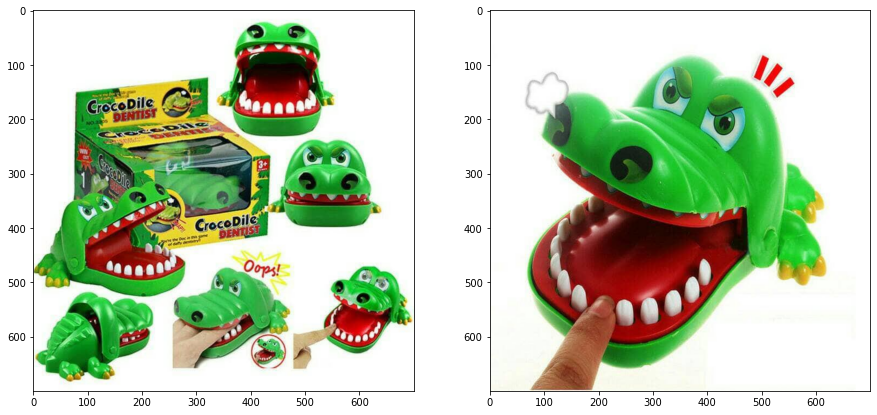

In [85]:
displayCompare("train_3566117367", "train_3911334027")